# Roof Semantic Segmentation

In this Jupyter Notebook we take a set of satellite images provided by Dida and train a U-Net model to perform semantic segmentation for the rooftops in the photos. 

The inspiration for this particular approach was from the following tutorial: https://www.tensorflow.org/tutorials/images/segmentation
I adapted the tensorflow implementation to pytorch.

## Load libraries

In [1]:
import os
import numpy as np

# torch libraries
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

# torchvision libraries
import torchvision
from torchvision import transforms
from torch.nn import functional as F
from torchvision.transforms.functional import pil_to_tensor


# custom libraries
from data import RoofDataSet, open_image
from utils import show_predictions, pred_to_pil


import matplotlib.pyplot as plt
%matplotlib inline


## Load Data

In [2]:
os.chdir('.')
data_dir = '../data'

dida_train = RoofDataSet(data_dir, transform = True, normalize = True, binary_mask = True)
dida_val = RoofDataSet(data_dir, transform = True, normalize = True, binary_mask = True, mode = 'val')

print(f'Number of training examples: {len(dida_train)}')
print(f'Number of validation examples: {len(dida_val)}')


Number of training examples: 20
Number of validation examples: 4


There are only 20 training examples, so we will need to do data augmentation. Let's take a look at some examples. 

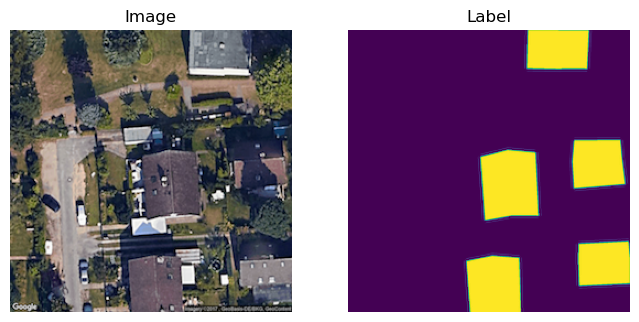

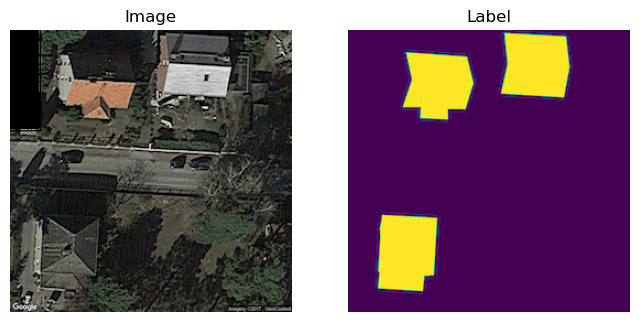

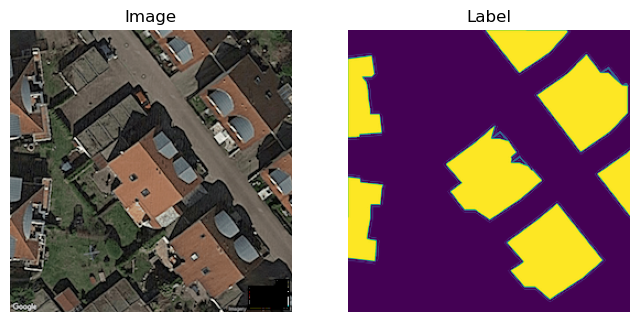

In [3]:
# Look at a few examples of data set

images = dida_train.images
labels = dida_train.labels
for i in range(3):
    img = images[i]
    label = labels[i]
    fig, ax = plt.subplots(1, 2, figsize = (8, 4))

    # plot image
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Image')

    # plot label
    ax[1].imshow(label)
    ax[1].axis('off')
    ax[1].set_title('Label')

    plt.show()
    plt.close(fig)
    

We added in some data augmentation into the RoofDataSet class, lets check to make sure that it transforms both the original image and the label in the same way. 

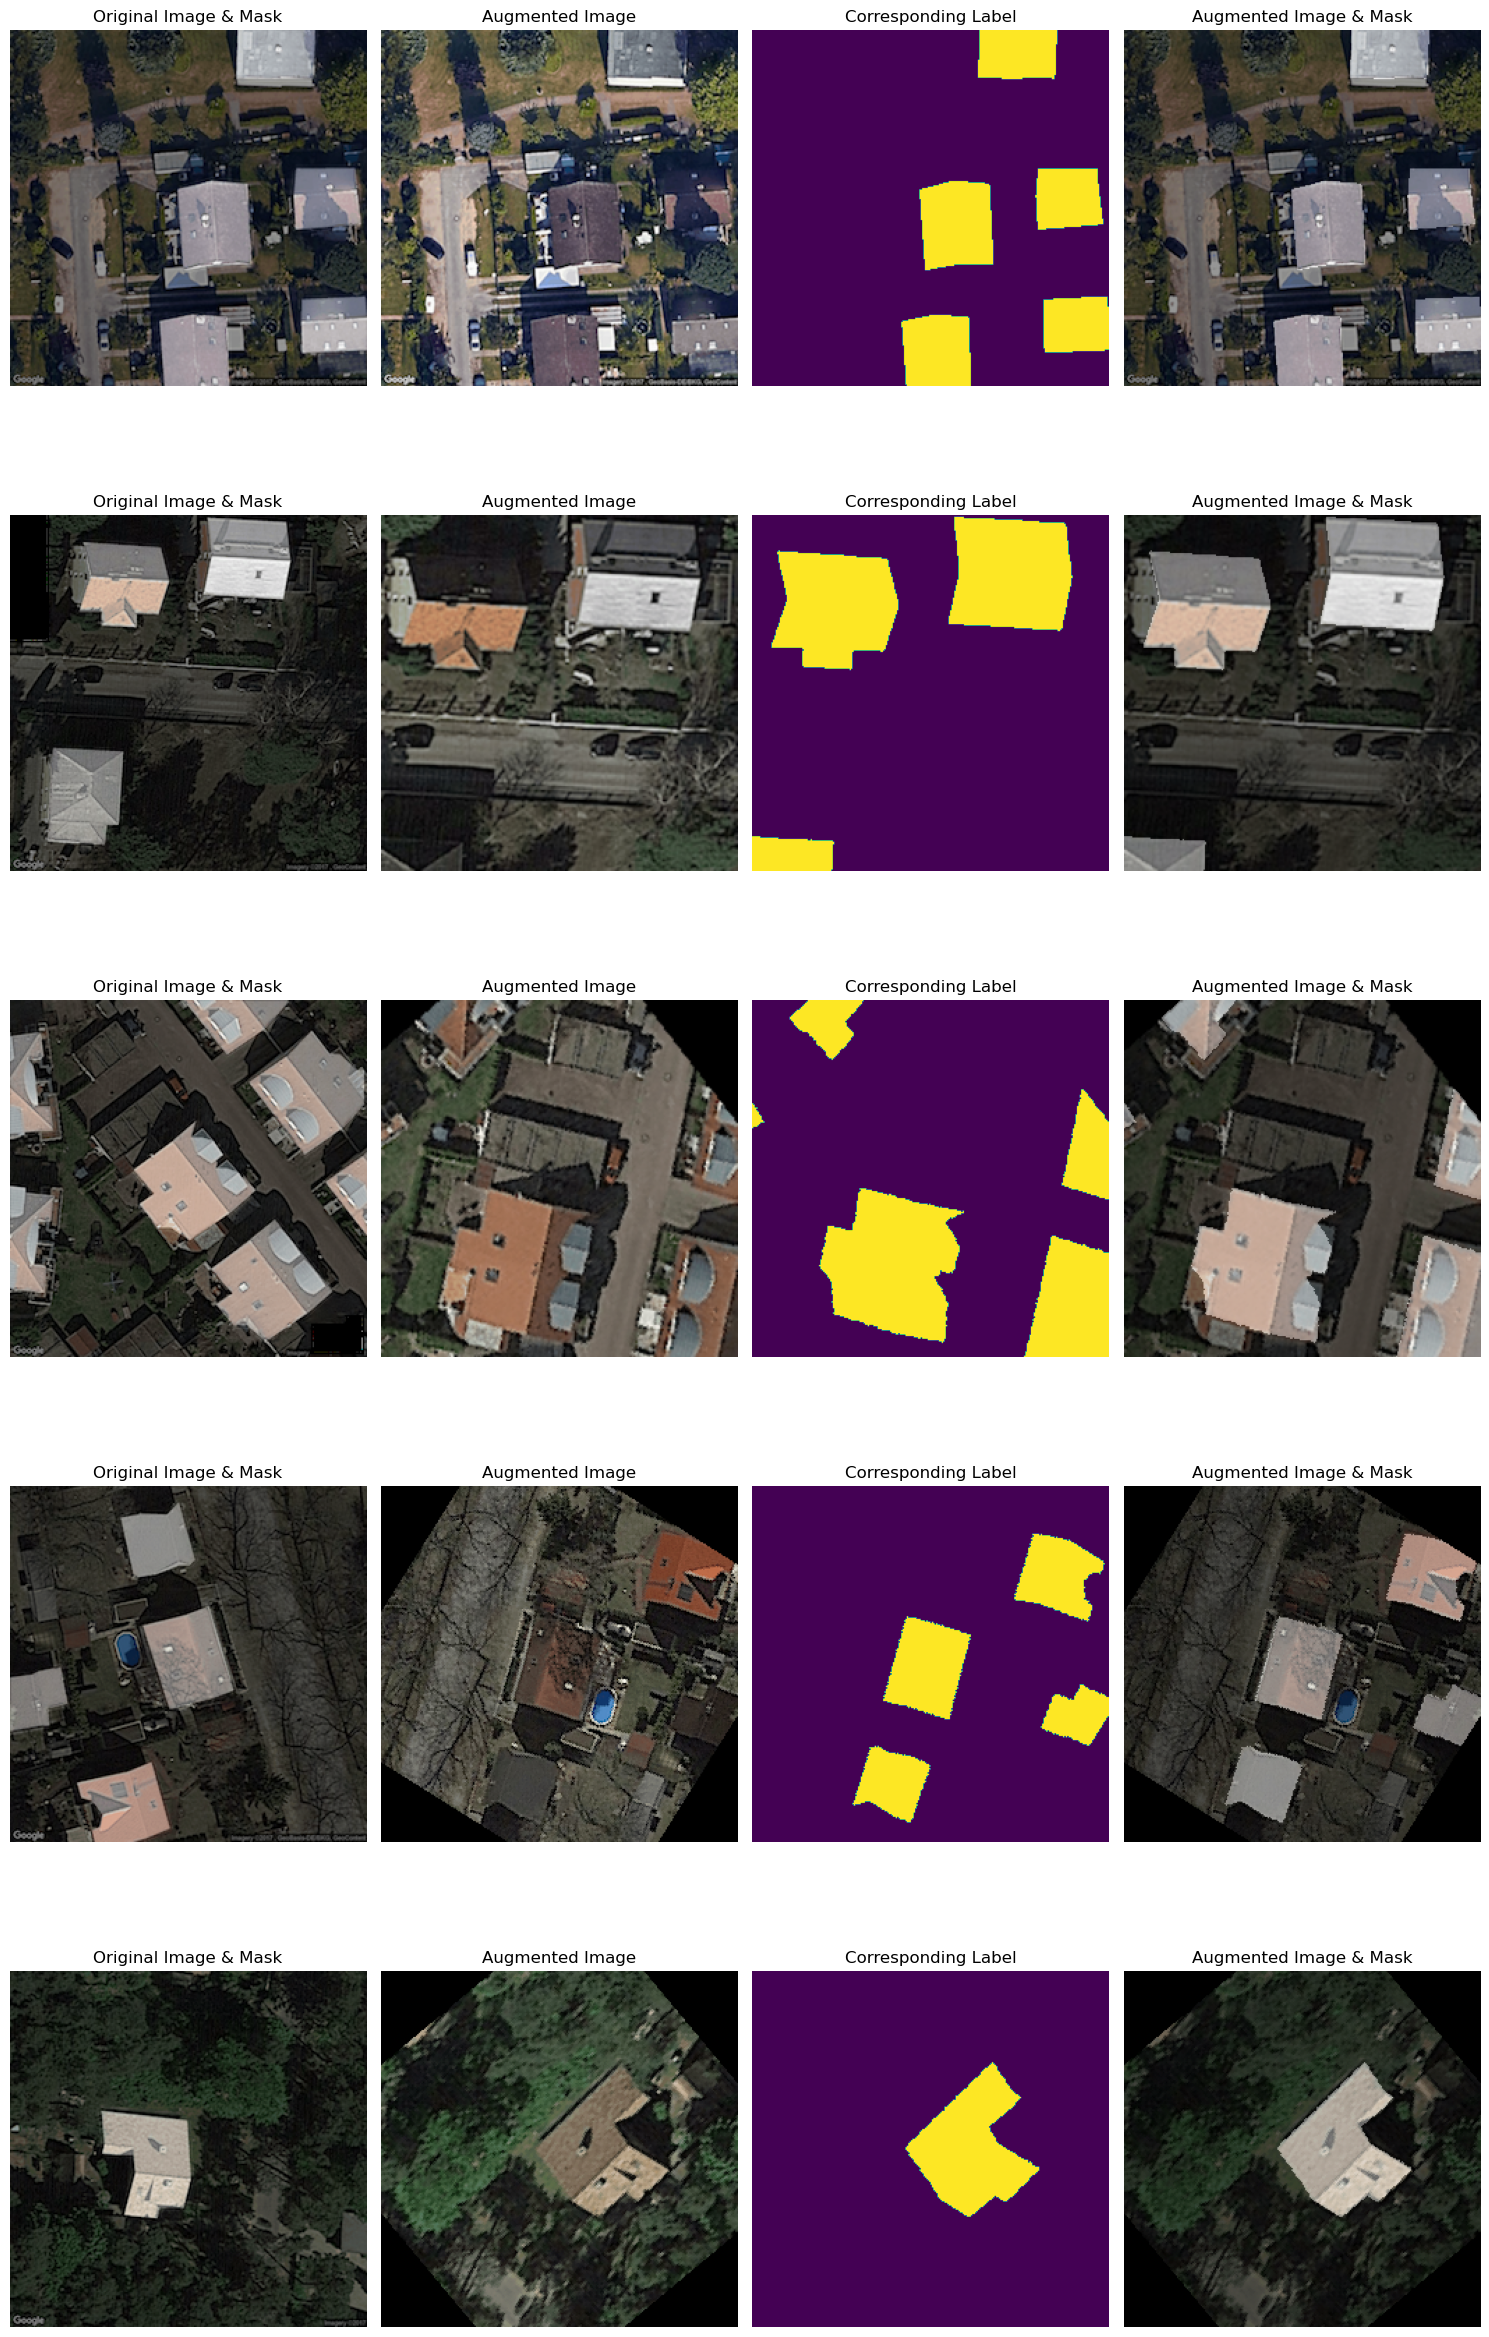

In [4]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms

# Create the dataset without normalization
dida_ds_vis = RoofDataSet(data_dir, normalize = False, transform=True, binary_mask = True)

# Choose some indices to visualize
indices_to_visualize = [0, 1, 2, 3, 4]

# Visualize original and augmented images along with labels
fig, axs = plt.subplots(len(indices_to_visualize), 4, figsize=(15, 5 * len(indices_to_visualize)))

for idx, i in enumerate(indices_to_visualize):
    original_image = dida_ds_vis.images[i]
    original_label = dida_ds_vis.labels[i]
    img, label = dida_ds_vis[i]

    # Original Image and Label
    axs[idx, 0].imshow(original_image)
    axs[idx, 0].set_title("Original Image & Mask")
    axs[idx, 0].axis("off")

    if label is not None:
        axs[idx, 0].imshow(original_label, cmap="gray", alpha=0.4)

    # Augmented Image
    axs[idx, 1].imshow(transforms.ToPILImage()(img))
    axs[idx, 1].set_title("Augmented Image")
    axs[idx, 1].axis("off")

    # Corresponding Label
    if label is not None:
        axs[idx, 2].imshow(transforms.ToPILImage()(label))
        axs[idx, 2].set_title("Corresponding Label")
    else:
        axs[idx, 2].set_title("Label Not Available")
    axs[idx, 2].axis("off")

    # augmented image and label
    axs[idx, 3].imshow(transforms.ToPILImage()(img))
    axs[idx,3].set_title('Augmented Image & Mask')
    axs[idx,3].axis('off')

    if label is not None:
        axs[idx,3].imshow(transforms.ToPILImage()(label), cmap="gray", alpha=0.4)

plt.tight_layout()
plt.show()


## Initialize U-Net Model

In [5]:
from model import UNetMobileNet

model = UNetMobileNet(output_channels = 1)

/Users/dominicculver/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dominicculver/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


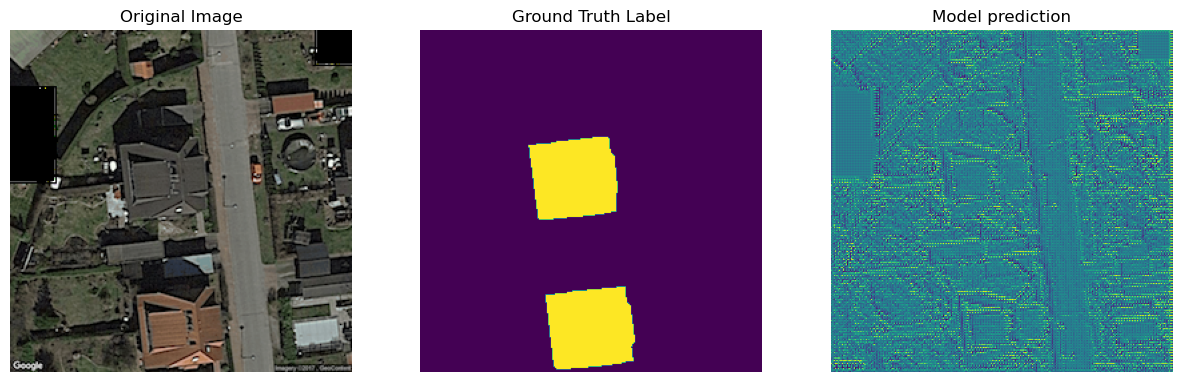

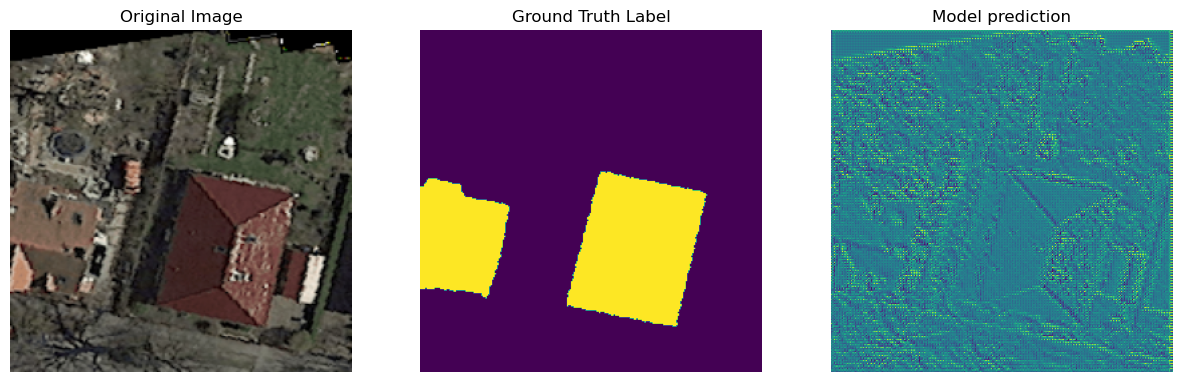

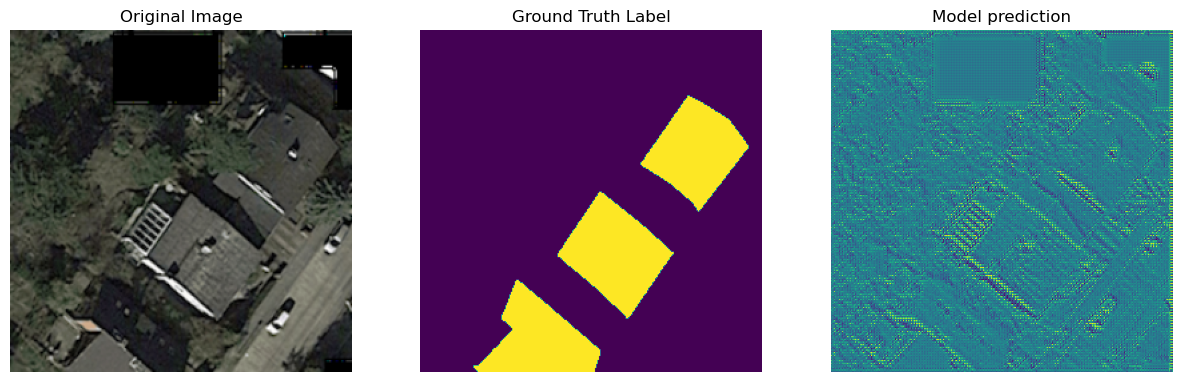

In [6]:
show_predictions(dida_train, model, binary_pred=False)

For fun, let's see how many parameters the model has.

In [7]:
total_params = 0
for param in model.parameters():
    total_params += param.numel()

total_params

6469473

## Training Loop

We use the Adam optimizer and binary crossentropy loss function

In [8]:
# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
learning_rate = 0.0001
batch_size = 5
num_epochs = 50


# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# get dataloader from dataset
dida_train_dl = DataLoader(dida_train, batch_size = batch_size, shuffle = True)
dida_val_dl = DataLoader(dida_val)

# create empty lists to store training and validation loss
train_losses = []
val_losses = []

# set model to device
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(dida_train_dl):
        # Move inputs and labels to the device (e.g., GPU) if available
        inputs, labels = inputs.to(device), labels.to(device)
        #print(labels.unique())
        #print(labels.shape)
        # print(labels.unsqueeze(1).float().shape)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        #print(outputs.shape)

        # Crop the model's output to match the size of the labels (256x256)
        labels = F.interpolate(labels, size=outputs.size()[2:], mode='nearest') # more methodical way of making label and outputs same size
        # outputs = outputs[:, :, :256, :256] # quick cropping, output of model is (bs, 1, 257, 257)
        # print(outputs.shape)

        # Compute the loss
        loss = criterion(outputs, labels)  # BCELoss expects a tensor of shape (batch_size, 1)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        # Print training progress
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] Batch [{batch_idx + 1}/{len(dida_train_dl)}] Loss: {loss.item():.4f}")
    
    # Calculate the average training loss for the epoch
    average_train_loss = running_loss / len(dida_train_dl)
    train_losses.append(average_train_loss)
    
    # now evaluate on validation set
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for image, label in dida_val_dl:
            output = model(image)[:, :, :256, :256]
            val_loss += criterion(output, label).item()

    # calculate the average validation loss for the epoch
    average_val_loss = val_loss / len(dida_val_dl)
    val_losses.append(average_val_loss)

        


    print(f"Epoch [{epoch + 1}/{num_epochs}] Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}")

print("Training complete!")



Epoch [1/50] Average Train Loss: 0.6270, Average Val Loss: 0.6277
Epoch [2/50] Average Train Loss: 0.4992, Average Val Loss: 0.5836
Epoch [3/50] Average Train Loss: 0.4115, Average Val Loss: 0.5501
Epoch [4/50] Average Train Loss: 0.3706, Average Val Loss: 0.4777
Epoch [5/50] Average Train Loss: 0.3305, Average Val Loss: 0.4287
Epoch [6/50] Average Train Loss: 0.2936, Average Val Loss: 0.3740
Epoch [7/50] Average Train Loss: 0.2781, Average Val Loss: 0.3312
Epoch [8/50] Average Train Loss: 0.2576, Average Val Loss: 0.2872
Epoch [9/50] Average Train Loss: 0.2353, Average Val Loss: 0.2696
Epoch [10/50] Average Train Loss: 0.2202, Average Val Loss: 0.2558
Epoch [11/50] Average Train Loss: 0.2177, Average Val Loss: 0.2319
Epoch [12/50] Average Train Loss: 0.2099, Average Val Loss: 0.2254
Epoch [13/50] Average Train Loss: 0.1966, Average Val Loss: 0.2022
Epoch [14/50] Average Train Loss: 0.2017, Average Val Loss: 0.1985
Epoch [15/50] Average Train Loss: 0.1870, Average Val Loss: 0.2032
Epoc

Now lets plot the training and validation loss. 

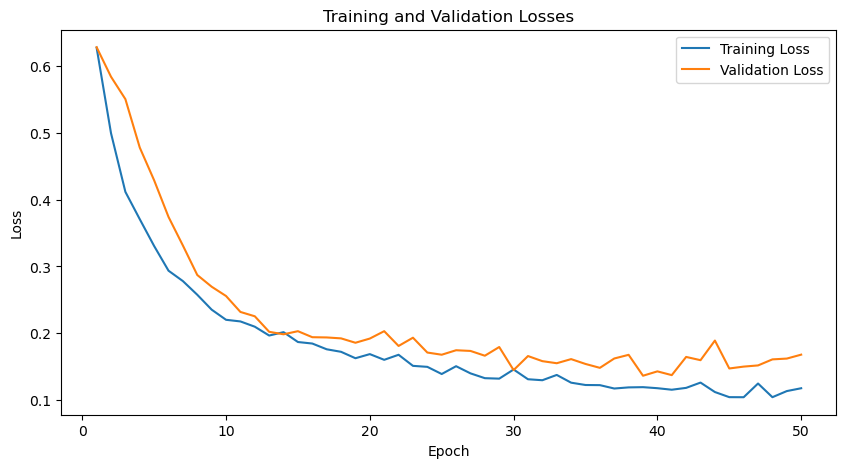

In [9]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


The curve is a good start! The training and validation loss generally speaking stay close together so we aren't overfitting! The curve flattens out towards the end but let's see if training a bit longer makes any noticeable difference. 

In [12]:
# initialize new model
model2 = UNetMobileNet(output_channels=1)

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
learning_rate = 0.0001
batch_size = 5
num_epochs = 100


# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model2.parameters(), lr=learning_rate)

# get dataloader from dataset
dida_train_dl = DataLoader(dida_train, batch_size = batch_size, shuffle = True)
dida_val_dl = DataLoader(dida_val)

# create empty lists to store training and validation loss
train_losses = []
val_losses = []

# set model to device
model2.to(device)

# Training loop
for epoch in range(num_epochs):
    model2.train()  # Set the model to training mode
    running_loss = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(dida_train_dl):
        # Move inputs and labels to the device (e.g., GPU) if available
        inputs, labels = inputs.to(device), labels.to(device)
        #print(labels.unique())
        #print(labels.shape)
        # print(labels.unsqueeze(1).float().shape)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model2(inputs)
        #print(outputs.shape)

        # Crop the model's output to match the size of the labels (256x256)
        labels = F.interpolate(labels, size=outputs.size()[2:], mode='nearest') # more methodical way of making label and outputs same size
        # outputs = outputs[:, :, :256, :256] # quick cropping, output of model is (bs, 1, 257, 257)
        # print(outputs.shape)

        # Compute the loss
        loss = criterion(outputs, labels)  # BCELoss expects a tensor of shape (batch_size, 1)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        # Print training progress
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] Batch [{batch_idx + 1}/{len(dida_train_dl)}] Loss: {loss.item():.4f}")
    
    # Calculate the average training loss for the epoch
    average_train_loss = running_loss / len(dida_train_dl)
    train_losses.append(average_train_loss)
    
    # now evaluate on validation set
    model2.eval()
    val_loss = 0.0

    with torch.no_grad():
        for image, label in dida_val_dl:
            output = model2(image)[:, :, :256, :256]
            val_loss += criterion(output, label).item()

    # calculate the average validation loss for the epoch
    average_val_loss = val_loss / len(dida_val_dl)
    val_losses.append(average_val_loss)

        


    print(f"Epoch [{epoch + 1}/{num_epochs}] Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}")

print("Training complete!")




/Users/dominicculver/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dominicculver/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] Average Train Loss: 0.9324, Average Val Loss: 0.6787
Epoch [2/100] Average Train Loss: 0.7748, Average Val Loss: 0.6379
Epoch [3/100] Average Train Loss: 0.6741, Average Val Loss: 0.6282
Epoch [4/100] Average Train Loss: 0.5873, Average Val Loss: 0.5833
Epoch [5/100] Average Train Loss: 0.5180, Average Val Loss: 0.5592
Epoch [6/100] Average Train Loss: 0.4675, Average Val Loss: 0.5059
Epoch [7/100] Average Train Loss: 0.4269, Average Val Loss: 0.4727
Epoch [8/100] Average Train Loss: 0.3901, Average Val Loss: 0.4093
Epoch [9/100] Average Train Loss: 0.3534, Average Val Loss: 0.3650
Epoch [10/100] Average Train Loss: 0.3377, Average Val Loss: 0.3517
Epoch [11/100] Average Train Loss: 0.3260, Average Val Loss: 0.3244
Epoch [12/100] Average Train Loss: 0.3185, Average Val Loss: 0.3065
Epoch [13/100] Average Train Loss: 0.3006, Average Val Loss: 0.2876
Epoch [14/100] Average Train Loss: 0.2850, Average Val Loss: 0.2686
Epoch [15/100] Average Train Loss: 0.2780, Average Val Lo

In [ ]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


The graph seems to indicate that the training and validation losses start to deviate around 60 epochs or when the losses dip under 0.2. So it is unlikely that training for more than 60 epochs will be beneficial. 

Now let's see how the model performs on the test set!

In [10]:
dida_ds_test = RoofDataSet(data_dir, transform = False, normalize = True, mode = 'test')
print(f'Number of test examples: {len(dida_ds_test)}')

Number of test examples: 5


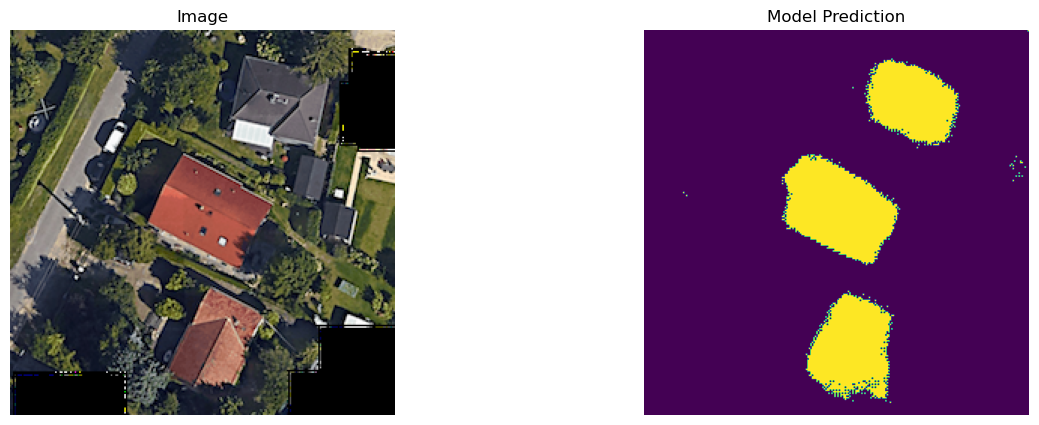

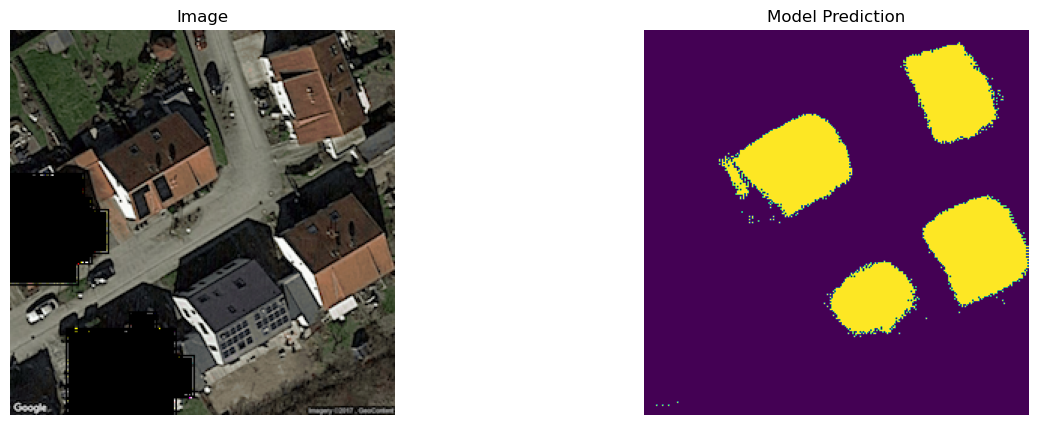

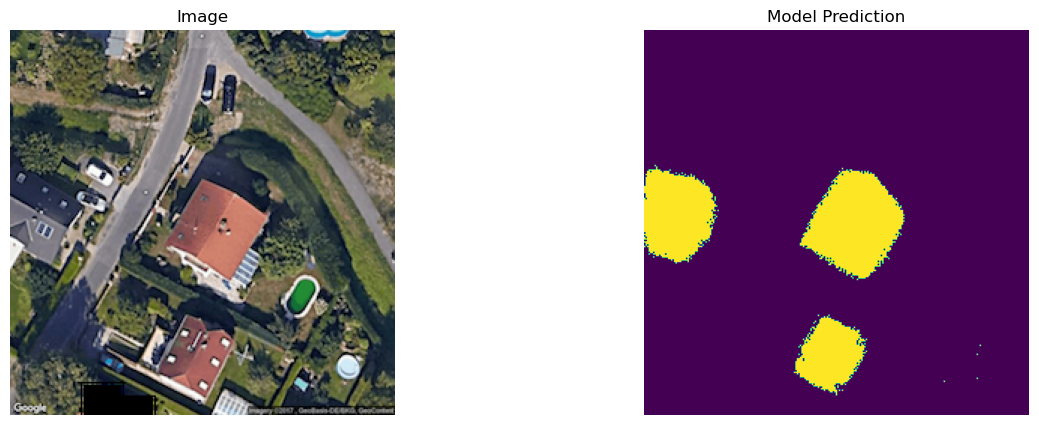

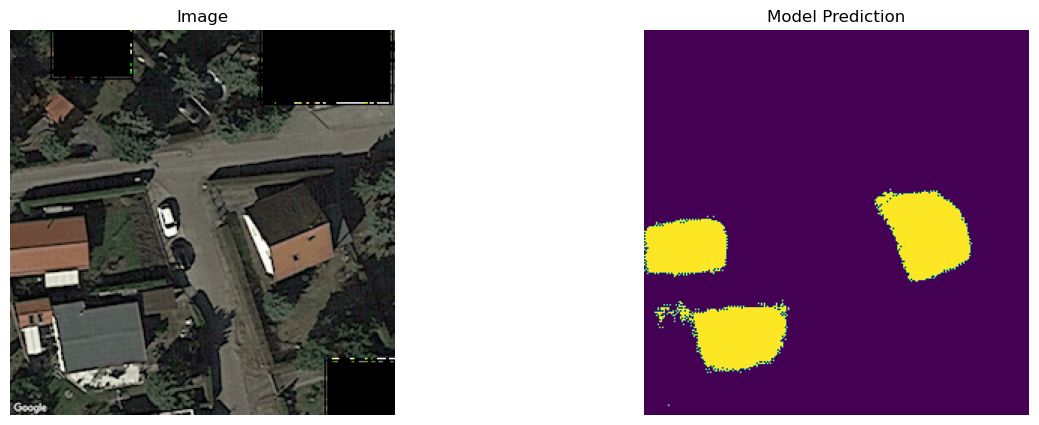

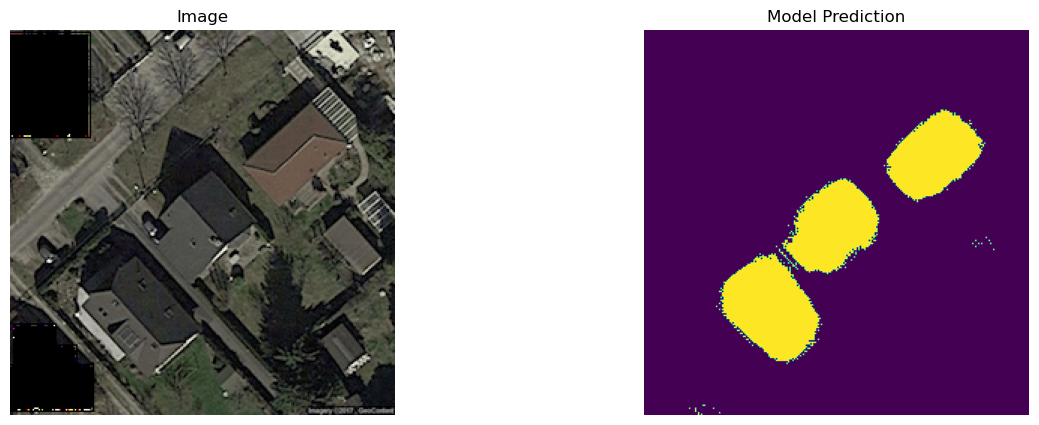

In [11]:
# predictions from the first model
show_predictions(dida_ds_test, model, max_num = 5, binary_pred = True)

In [ ]:
# predictions from the first model
show_predictions(dida_ds_test, model2, max_num = 5, binary_pred = True)

In [ ]:
image = dida_ds_test[0]
image.shape

In [ ]:
from pathlib import Path
import torchvision.transforms.functional as TF

def save_predictions(input_dir, output_dir, model):

    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    img_mean = [0.485, 0.456, 0.406]  # from pretrained MobileNet
    img_std = [0.229, 0.224, 0.225]  # from pretrained MobileNet

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    
    paths = sorted(
            [p for p in input_dir.iterdir() if p.is_file()]
        ) 
    images = [(open_image(p), p.name) for p in paths]

    model.eval()
    with torch.no_grad():
        for image_pil, name in images:
            
            image_pil = image_pil.convert('RGB')
            image_tensor = TF.to_tensor(image_pil)
            image_tensor = torch.unsqueeze(image_tensor, 0)

            image_tensor = TF.normalize(image_tensor, img_mean, img_std)
            prediction = model(image_tensor)
            prediction = (prediction > 0.5).float()

            prediction = pred_to_pil(prediction)
            

            output_path = os.path.join(output_dir, name)

            prediction.save(output_path)

    print(f'Saved predictions!')


input_dir = '../data/test/images'
output_dir = '../predictions'
save_predictions(input_dir, output_dir, model2)

It appears that the second model does predict the roofs slightly better than the first. So it seems that training for 60-70 epochs is a good range. Other things to try could be the following 

* decaying learning rate
* turning off the training for the MobileNet backbone in our U-Net architecture
* Using a different backbone from MobileNet, e.g. ResNet
* Would different optimizers, such as AdamW, work better?
* Should we use a different loss function, e.g. Dice or Jacques loss?